In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = 'flowers'
class_names = [name for name in os.listdir(data_dir)]
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [175]:
image_height = 120
image_width = 120

batch_size = 32

In [176]:
def get_label(path):
    parts = tf.strings.split(path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [177]:
def decode_image(image):
    image = tf.io.decode_jpeg(image, channels=3)  #channels = 1 轉成灰階
    return tf.image.resize(image, [image_height, image_width])

In [178]:
def process_path(path):
    label = get_label(path)
    image = tf.io.read_file(path)
    image = decode_image(image)
    return image, label

In [199]:
autotune = tf.data.experimental.AUTOTUNE #自動選擇最優線路

dataset = tf.data.Dataset.list_files(f'{data_dir}/*/*.jpg', shuffle=True)
dataset = dataset.map(process_path, num_parallel_calls=autotune)

train_size = int(len(dataset) * 0.9)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

val_size = int(len(train_dataset) * 0.2)
val_dataset = train_dataset.take(val_size)
train_dataset = train_dataset.skip(val_size)

In [180]:
def configure_dataset(ds):
    ds = ds.shuffle(1000)
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.prefetch(autotune)
    return ds

In [200]:
train_dataset = configure_dataset(train_dataset)
val_dataset = configure_dataset(val_dataset)
test_dataset = configure_dataset(test_dataset)

In [201]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(image_width, image_height, 3)),  #如果更改為灰階圖片channel =1 ，input_shape也要改為1
#     keras.layers.experimental.preprocessing.RandomFlip(),                #翻轉horizontal_and_vertical
#     keras.layers.experimental.preprocessing.RandomRotation(0.1),       #依0.2比例旋轉
    keras.layers.experimental.preprocessing.Rescaling(1./255),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, 3, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_15 (Rescaling)     (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 118, 118, 32)      896       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 57, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 13, 13, 128)     

In [202]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [203]:
hist = model.fit(train_dataset,
                 epochs=30,
                 validation_data=val_dataset)

Epoch 1/30
83/83 [==============================] - 63s 453ms/step - loss: 1.5463 - accuracy: 0.2918 - val_loss: 1.2250 - val_accuracy: 0.4712
Epoch 2/30
83/83 [==============================] - 32s 385ms/step - loss: 1.2534 - accuracy: 0.4660 - val_loss: 1.0687 - val_accuracy: 0.5576
Epoch 3/30
83/83 [==============================] - 32s 385ms/step - loss: 1.1281 - accuracy: 0.5447 - val_loss: 0.9504 - val_accuracy: 0.6348
Epoch 4/30
83/83 [==============================] - 32s 385ms/step - loss: 0.9982 - accuracy: 0.5931 - val_loss: 0.8240 - val_accuracy: 0.7030
Epoch 5/30
83/83 [==============================] - 33s 399ms/step - loss: 0.8825 - accuracy: 0.6522 - val_loss: 0.7721 - val_accuracy: 0.7045
Epoch 6/30
83/83 [==============================] - 33s 399ms/step - loss: 0.7580 - accuracy: 0.7091 - val_loss: 0.6525 - val_accuracy: 0.7576
Epoch 7/30
83/83 [==============================] - 33s 397ms/step - loss: 0.6690 - accuracy: 0.7483 - val_loss: 0.7046 - val_accuracy: 0.7394

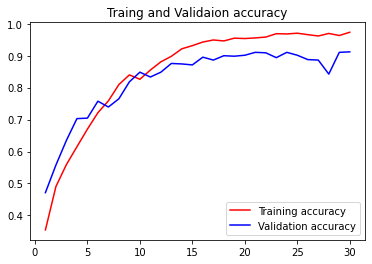

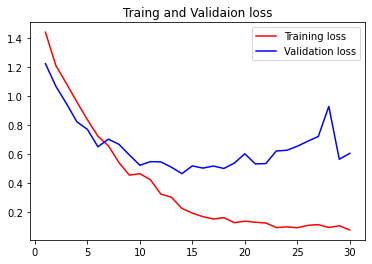

In [204]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Traing and Validaion accuracy')
plt.legend()
plt.savefig('RGB3 acc.jpeg')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Traing and Validaion loss')
plt.legend()
plt.savefig('RGB3 loss.jpeg')

plt.show()

In [206]:
predictions = model.predict(test_dataset)

index = 19

for img, label in test_dataset.take(1):
    print('True label:', class_names[label[index]])
    img = keras.preprocessing.image.array_to_img(img[index])
    

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions[index])], 100 * np.max(predictions[index]))
)

True label: daisy
This image most likely belongs to daisy with a 100.00 percent confidence.
